# Artificial Type Dataset Processing + Multithreaded Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

The dataset is defined to be 15GB.

The sample count varies to showcase differences in performance with the same amount of data.

Every experiment was done 5 times, most are done with two datatypes: `uint8` and `float32`, but at some point we did not use `uint8` anymore because the results were virtually identical.

In [15]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import matplotlib.patches as mpatches

from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
online_time_palette = sns.color_palette("CMRmap_r")
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

local_fig_dir = "misc"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### X.1 Calculation on how many samples we need for differing sample storage consumptions

Calculating the float32 ones, as we want the sample counts to be natural numbers.

To calculate the uint8 sample counts, we need to multiply the the float32 ones times 4.

In [9]:
base_vector = 2500 # defined in the type_demo.py
float32_in_mb = 4 / 1000**2 # 32bit -> 4 byte
min_sample_size_mb = base_vector * float32_in_mb # smallest possible sample storage consumption
max_dataset_size_mb = 15 * 1000.0 # maximum total storage consumption in MB

sample_dict = {
    "vector_lines": [],
    "vector_lines_uint8": [],
    "sample_storage_consumption_mb": [],
    "sample_count": []
}

for count in range(0,12):
    
    vector_lines = 2**count
    sample_storage_consumption_mb = min_sample_size_mb * vector_lines
    sample_count = int(max_dataset_size_mb / sample_storage_consumption_mb)
    
    sample_dict["vector_lines"].append(vector_lines)
    sample_dict["vector_lines_uint8"].append(vector_lines * 4)
    sample_dict["sample_storage_consumption_mb"].append(sample_storage_consumption_mb)
    sample_dict["sample_count"].append(sample_count)

pd.DataFrame(sample_dict)

,vector_lines,vector_lines_uint8,sample_storage_consumption_mb,sample_count
0,1,4,0.01,1500000
1,2,8,0.02,750000
2,4,16,0.04,375000
3,8,32,0.08,187500
4,16,64,0.16,93750
5,32,128,0.32,46875
6,64,256,0.64,23437
7,128,512,1.28,11718
8,256,1024,2.56,5859
9,512,2048,5.12,2929


### X.2 Some helper functions

In [10]:
def read_datatype_log(path_to_cum_df, path_to_cum_dstat_df, proc_type):
    '''Filter the type cumulative dataframes
    For easier evaluation, we drop the unnecessary columns.
    '''
    analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                     , path_to_cum_df = path_to_cum_df)
    cum_dstat_df = analysis.to_cum_dstat_df()
    cum_df       = analysis.to_cum_df()
    # need to sort the strategies for some reason as they are not ascending
    cum_df = cum_df.sort_values(by='split_name')
    strategies   = list(cum_df.split_name.unique())
    # add the average storage consumption per sample
    cum_df["per_sample_size_MB"] = cum_df["shard_cum_size_MB"] / cum_df["sample_count"]
    # add the per byte online processing time (needed for speedup calculation)
    cum_df["per_byte_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["shard_cum_size_MB"]
    # add the datatype as column to each df
    cum_df["proc_type"] = proc_type
    cum_dstat_df["proc_type"] = proc_type
    
    # delete not needed columns
    cum_df = cum_df.drop('shard_count', 1)
    #cum_df = cum_df.drop('thread_count', 1)
    #cum_df = cum_df.drop('runs_count', 1)
    #cum_df = cum_df.drop('runs_total', 1)
    cum_df = cum_df.drop('compression_type', 1)
    cum_df = cum_df.drop('storage_type', 1)
    #cum_df = cum_df.drop('throughput_sps', 1)
    cum_df = cum_df.drop('split_name', 1)
    
    cum_dstat_df = cum_dstat_df.drop('shard_count', 1)
    #cum_dstat_df = cum_dstat_df.drop('thread_count', 1)
    #cum_dstat_df = cum_dstat_df.drop('run', 1)
    cum_dstat_df = cum_dstat_df.drop('compression_type', 1)
    cum_dstat_df = cum_dstat_df.drop('storage_type', 1)
    
    return cum_df, cum_dstat_df

def extract_online_processing_frames(sample_count, df, dstat_df):
    '''Extracts the online processing time from the dataframe.
    Filters the dstat_df by that online processing time.
    '''        
    max_offline_processing_time_s = df.query(
        f"sample_count=={sample_count}")["offline_processing_and_save_time_s"].mean()
    
    filtered_dstat_df = dstat_df.query(
        f"sample_count=='{sample_count}' and rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df


def return_online_df(df, dstat_df):
    '''Returns the dstat dataframe filteredy by online processing time
    Also prints a summary about the network reads
    '''
    sample_counts = df.sample_count.unique()
    frames = [extract_online_processing_frames(sample_count=sample_count
                                              ,df=df
                                              ,dstat_df=dstat_df) for sample_count in sample_counts]
    online_dstat_df = pd.concat(frames)
    
    for sample_count in np.sort(df.sample_count.unique()):
    
        avg_online_processing_time = df.query(
            f"sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
        print("---------------------------------------")
        print(f"-- {sample_count} Network Read in MB/s --")
        print(f"-- {sample_count} Online Processing time: {int(avg_online_processing_time)}")
    
        temp_df = online_dstat_df.query(f"sample_count=='{sample_count}'")
        print(temp_df.describe()["net_read_mbs"])

    return online_dstat_df


def create_speedup_df(df):
    '''
    '''
    parallel_capability = {
      "thread_count": []
    , "sample_count": []
    , "speedup": []
    , "run": []
    , "proc_type": []
    }

    def add_capability(thread_count, sample_count, speedup, run, proc_type):
        parallel_capability["thread_count"] += [thread_count]
        parallel_capability["sample_count"] += [sample_count]
        parallel_capability["speedup"] += [speedup]
        parallel_capability["run"] += [run]
        parallel_capability["proc_type"] += [proc_type]

    for sample_count in df.sample_count.unique():
        for run_count in df.runs_count.unique():
            for thread_count in df.thread_count.unique():
                for proc_type in df.proc_type.unique():
                    online_times = df.query(f"sample_count=={sample_count} and \
                                                         runs_count=={run_count} and \
                                                         thread_count=={thread_count} and \
                                                         proc_type=='{proc_type}'")["throughput_sps"].to_numpy()
                    for online_time in online_times:
                        avg_step_t1_time = df.query(f"sample_count=={sample_count} and \
                                                                  runs_count=={run_count} and \
                                                                  thread_count=={1} and \
                                                                  proc_type=='{proc_type}'")["throughput_sps"].mean()
                        # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                        #if avg_step_t1_throughput < throughput:
                        #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                        #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                        #else:
                        #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                        #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                        ## now using speedup instead of increase/decrease factor
                        speedup = online_time / avg_step_t1_time
                        add_capability(thread_count=thread_count
                                     , sample_count=sample_count
                                     , speedup=speedup
                                     , run=run_count
                                     , proc_type=proc_type)

    parallel_capability_df = pd.DataFrame(parallel_capability)
    return parallel_capability_df

def plot_speedup(par_df, cum_df):
    sns.set(palette=threads_palette, font_scale=0.7)
    storage_consumption_per_samples = list(cum_df.query("runs_count==0") \
                                                        .groupby(by='sample_count') \
                                                        .mean()["per_sample_size_MB"].round(2))
    storage_consumption_per_samples.sort(reverse=True)
    def custom_format(label):
        if label > 0.9:
            return str(round(label,1))
        else:
            return str(label)
    sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]
    plt.figure(figsize=(4.5,2))

    plot = sns.barplot(
        x="sample_count",
        y="speedup",
        hue="thread_count",
        data=par_df.query("run==0")
    )
    plot.set_xticklabels(
        sc_per_samples_labels
      , rotation=10
    )
    plot.tick_params(axis='x', which='major', pad=-2.5)
    plot.tick_params(axis='y', which='major', pad=-2.5)
    #plot.set_title(f"Speedup for {cum_df.proc_type.unique()[0]}")
    plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Speedup")
    plot.set(ylim=(0, 8))
    plot.legend(title="Threads", ncol=1, labelspacing=0.05)
    return plot
    
def plot_online_time(cum_df):
    online_time_palette = sns.color_palette("CMRmap_r",4)
    sns.set(palette=online_time_palette, font_scale=0.6)
    storage_consumption_per_samples = list(cum_df.query("runs_count==0") \
                                                        .groupby(by='sample_count') \
                                                        .mean()["per_sample_size_MB"].round(2))
    storage_consumption_per_samples.sort(reverse=True)
    def custom_format(label):
        if label > 0.9:
            return str(round(label,1))
        else:
            return str(label)
    sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]
    plt.figure(figsize=(4.5,2))
    plot = sns.barplot(
        x="sample_count",
        y="online_processing_time_s",
        hue="thread_count",
        data=cum_df.query("runs_count==0")
    )
    plot.set_xticklabels(
        sc_per_samples_labels
      , rotation=10
    )
    plot.tick_params(axis='x', which='major', pad=-2.5)
    plot.tick_params(axis='y', which='major', pad=-2.5)
    plot.set_title(f"Online Processing Time for {cum_df.proc_type.unique()[0]}")
    plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online Processing Time in Seconds")
    #plot.set(ylim=(0, 8))
    plot.legend(title="Threads", ncol=1, labelspacing=0.05)
    
def print_experiment_count(cum_df):
    experiment_count_dict = {
        "sample_count": []
      , "thread_count": []
      , "thread_experiment_count": []
    }

    def get_experiment_count(df):
        '''Short helper'''
        return len(df.index)

    def add_to_dict(sample_count, thread_count, thread_experiment_count):
        '''Short helper'''
        experiment_count_dict["sample_count"] += [sample_count]
        experiment_count_dict["thread_count"] += [thread_count]
        experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]

    for sample_count in cum_df["sample_count"].unique():
        sample_experiment_count = get_experiment_count(cum_df.query(f"sample_count=={sample_count}"))
        # for each thread setting
        for thread_count in cum_df.query(f"sample_count=={sample_count}")['thread_count'].unique():
            thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
            add_to_dict(sample_count, thread_count, thread_experiment_count)

    experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
    return experiment_count_df

# 1. Read `np-raw` Logs

,sample_count,thread_count,thread_experiment_count
0,732,1,5
1,732,2,5
2,732,4,5
3,732,8,5
4,1464,1,5
5,1464,2,5
6,1464,4,5
7,1464,8,5
8,2929,1,5
9,2929,2,5


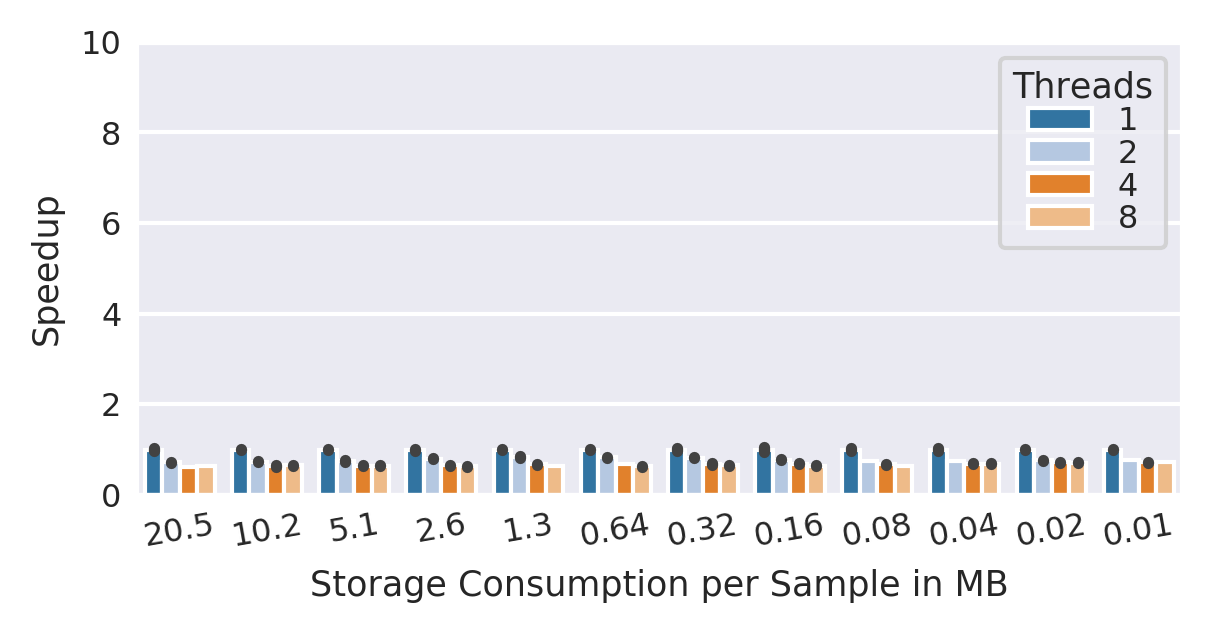

In [11]:
home_path = "../logs/type-logs/processing"
proc_type = "np-raw"
path_cum_df = f"{home_path}/{proc_type}/temp-a.csv"
path_dstat_df = f"{home_path}/{proc_type}/temp-b.csv"

cum_df, cum_dstat_df = read_datatype_log(path_to_cum_df = path_cum_df
                                 , path_to_cum_dstat_df = path_dstat_df
                                 , proc_type = proc_type )

strategies_renamed = ["read-dataset"]
cum_df = cum_df.sort_values(by=["sample_count", "thread_count"])
par_df = create_speedup_df(df=cum_df)
plt = plot_speedup(par_df=par_df, cum_df=cum_df)
plt.set(ylim=(0, 10))
save_fig("artificial-dataset-speedup-np-raw")
print_experiment_count(cum_df)

In [12]:
#plot_online_time(cum_df=cum_df)
cum_df.query("sample_count==732 \
          and thread_count==1").describe()["online_processing_time_s"]

count      5.000000
mean     649.754333
std       22.011623
min      614.485229
25%      642.841736
50%      658.421448
75%      664.317932
max      668.705200
Name: online_processing_time_s, dtype: float64

# 2. Read `np-class` logs

In [ ]:
home_path = "../logs/type-logs/processing"
proc_type = "np-class"
path_cum_df = f"{home_path}/{proc_type}/temp-a.csv"
path_dstat_df = f"{home_path}/{proc_type}/temp-b.csv"

cum_df, cum_dstat_df = read_datatype_log(path_to_cum_df = path_cum_df
                                 , path_to_cum_dstat_df = path_dstat_df
                                 , proc_type = proc_type )

strategies_renamed = ["read-dataset"]
cum_df = cum_df.sort_values(by=["sample_count", "thread_count"])
par_df = create_speedup_df(df=cum_df)
plot_speedup(par_df=par_df, cum_df=cum_df)
#print_experiment_count(cum_df)

count      5.000000
mean     170.089203
std       10.303663
min      158.496628
25%      161.950821
50%      169.844086
75%      176.580231
max      183.574280
Name: online_processing_time_s, dtype: float64

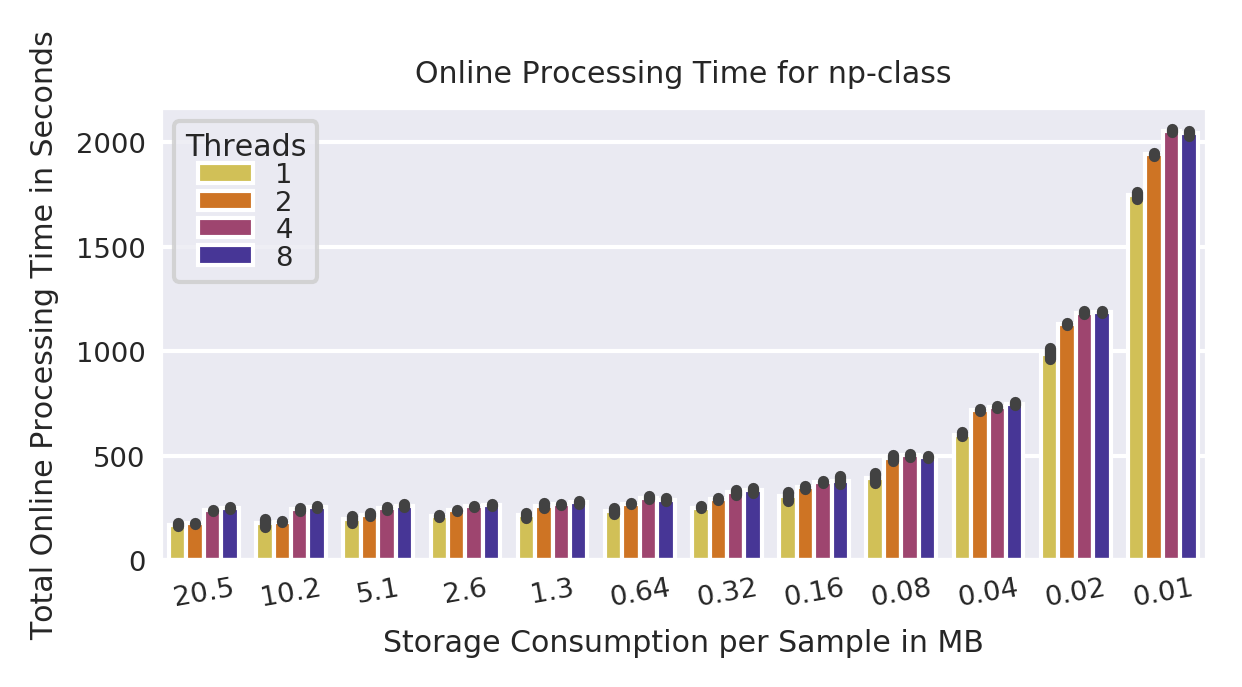

In [38]:
plot_online_time(cum_df=cum_df)
cum_df.query("sample_count==732 \
          and thread_count==1").describe()["online_processing_time_s"]

# 3. Read `np-class-global-var` logs

,sample_count,thread_count,thread_experiment_count
0,732,1,5
1,732,2,5
2,732,4,5
3,732,8,5
4,1464,1,5
5,1464,2,5
6,1464,4,5
7,1464,8,5
8,2929,1,5
9,2929,2,5


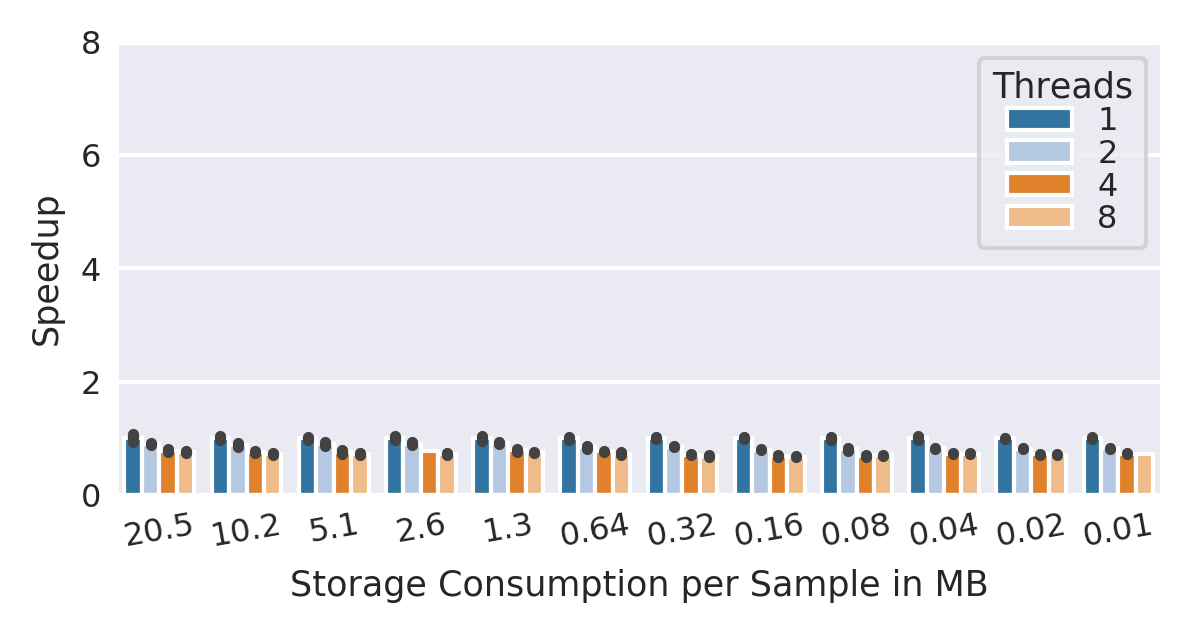

In [34]:
home_path = "../logs/type-logs/processing"
proc_type = "np-class-global-var"
path_cum_df = f"{home_path}/{proc_type}/temp-a.csv"
path_dstat_df = f"{home_path}/{proc_type}/temp-b.csv"

cum_df, cum_dstat_df = read_datatype_log(path_to_cum_df = path_cum_df
                                 , path_to_cum_dstat_df = path_dstat_df
                                 , proc_type = proc_type )

strategies_renamed = ["read-dataset"]
cum_df = cum_df.sort_values(by=["sample_count", "thread_count"])
par_df = create_speedup_df(df=cum_df)
plot_speedup(par_df=par_df, cum_df=cum_df)
print_experiment_count(cum_df)

count      5.000000
mean     150.905731
std       12.932965
min      129.343262
25%      149.175003
50%      155.235352
75%      159.257263
max      161.517853
Name: online_processing_time_s, dtype: float64

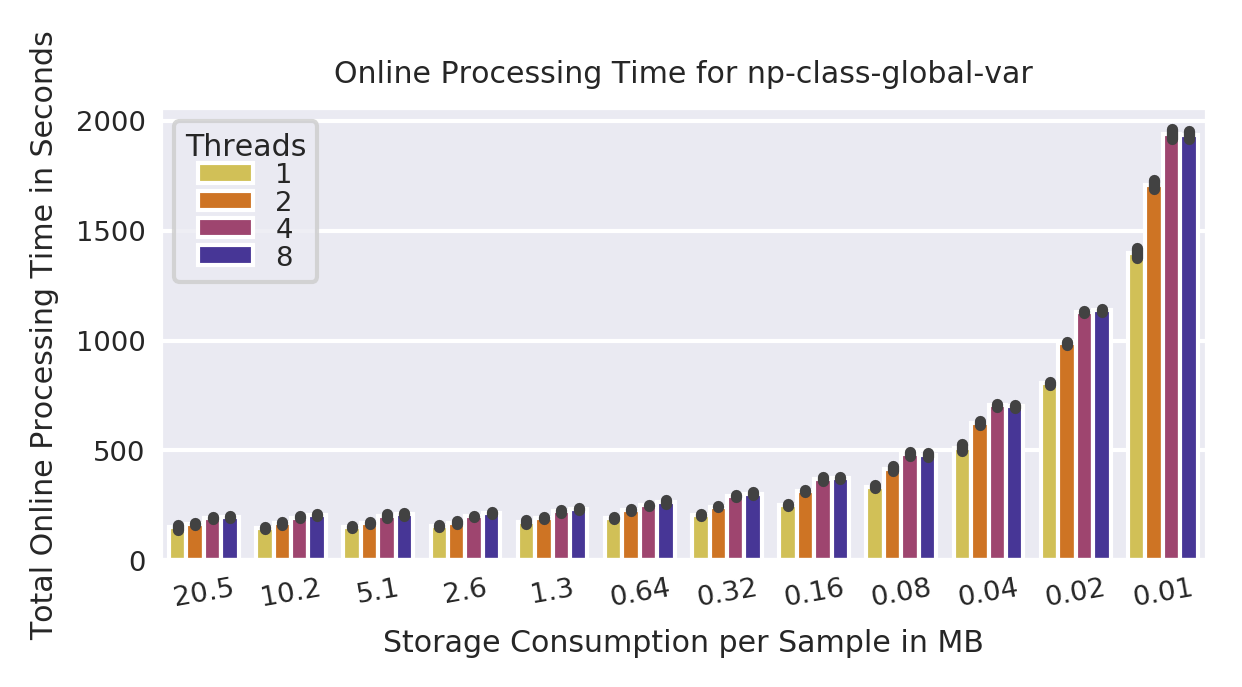

In [36]:
plot_online_time(cum_df=cum_df)
cum_df.query("sample_count==732 \
          and thread_count==1").describe()["online_processing_time_s"]

## 4. Read Tensorflow Raw Logs

,sample_count,thread_count,thread_experiment_count
0,732,1,5
1,732,2,6
2,732,4,9
3,732,8,14
4,1464,1,5
5,1464,2,6
6,1464,4,9
7,1464,8,14
8,2929,1,5
9,2929,2,6


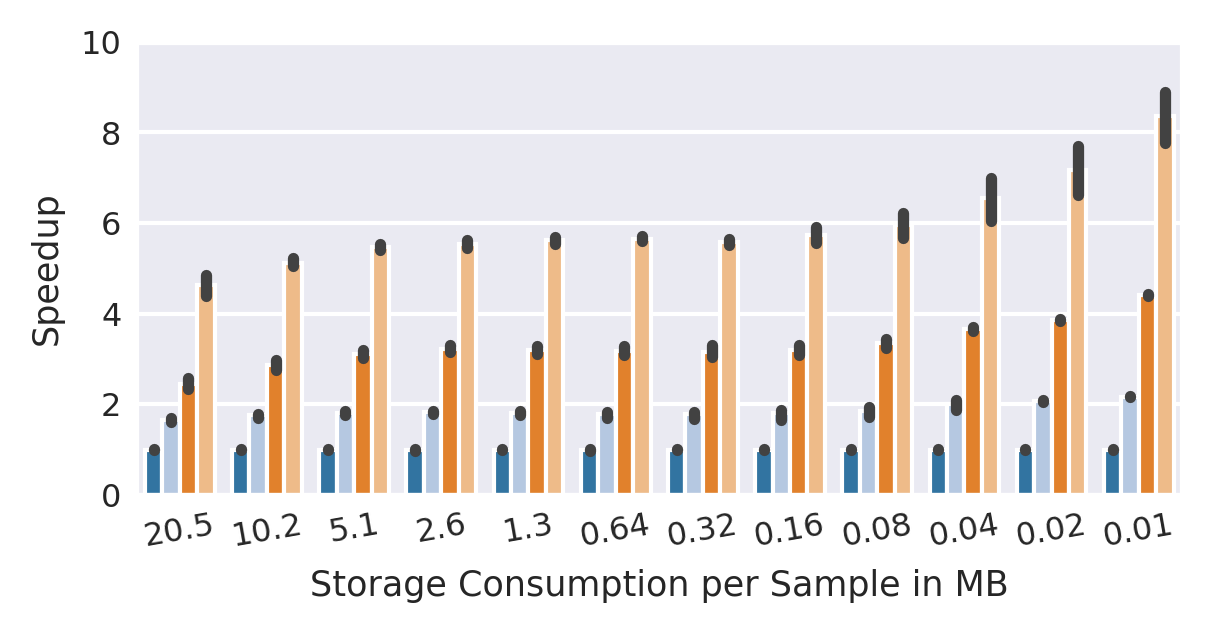

In [17]:
home_path = "../logs/type-logs/processing"
proc_type = "tf-raw"
path_cum_df = f"{home_path}/{proc_type}/temp-a.csv"
path_dstat_df = f"{home_path}/{proc_type}/temp-b.csv"

cum_df, cum_dstat_df = read_datatype_log(path_to_cum_df = path_cum_df
                                 , path_to_cum_dstat_df = path_dstat_df
                                 , proc_type = proc_type )

strategies_renamed = ["read-dataset"]
cum_df = cum_df.sort_values(by=["sample_count", "thread_count"])
par_df = create_speedup_df(df=cum_df)
plot = plot_speedup(par_df=par_df, cum_df=cum_df)
#plot.legend(title="Threads", ncol=1, labelspacing=0.05, loc=(0.005,0.58))
plot.get_legend().remove()
plot.set(ylim=(0, 10))
save_fig("artificial-dataset-speedup-tf-raw")
print_experiment_count(cum_df)

count      14.000000
mean     1904.580078
std       175.612930
min      1670.978882
25%      1744.439423
50%      1889.126770
75%      2083.665222
max      2137.192627
Name: online_processing_time_s, dtype: float64

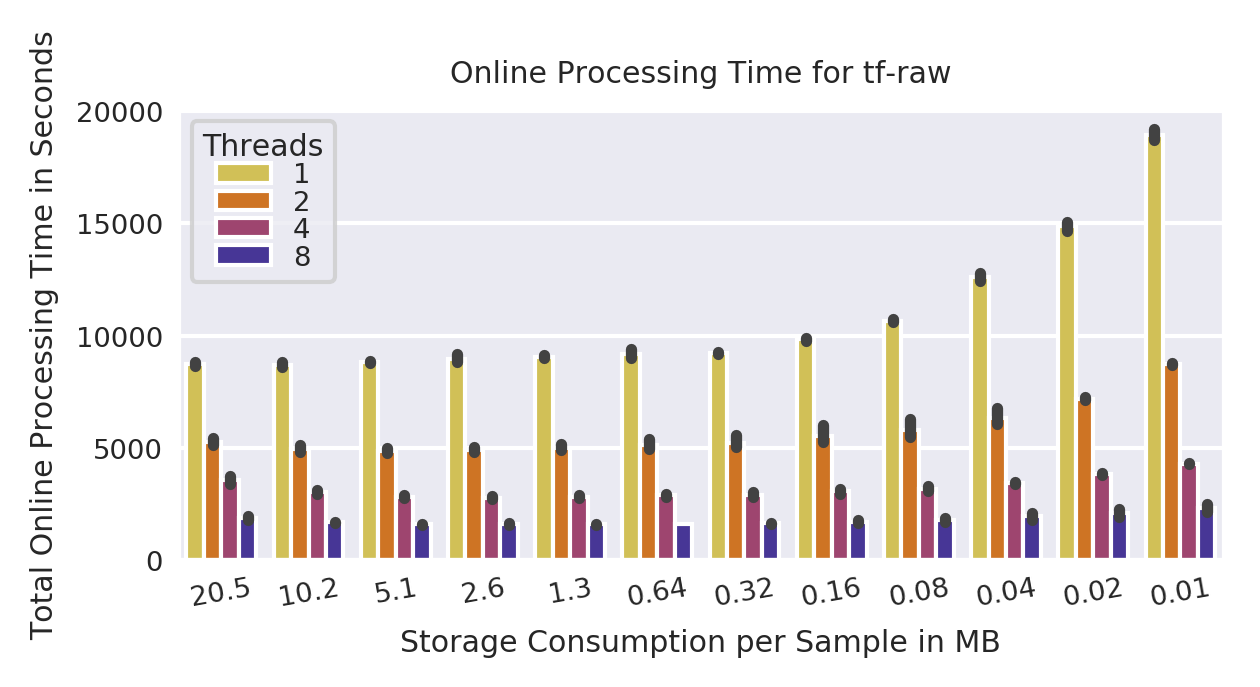

In [18]:
plot_online_time(cum_df=cum_df)
cum_df.query("sample_count==732 \
          and thread_count==8").describe()["online_processing_time_s"]

In [33]:
1905 / 650

2.9352850539291215

## 5. Read Tensorflow For Loop

[(0, 10)]

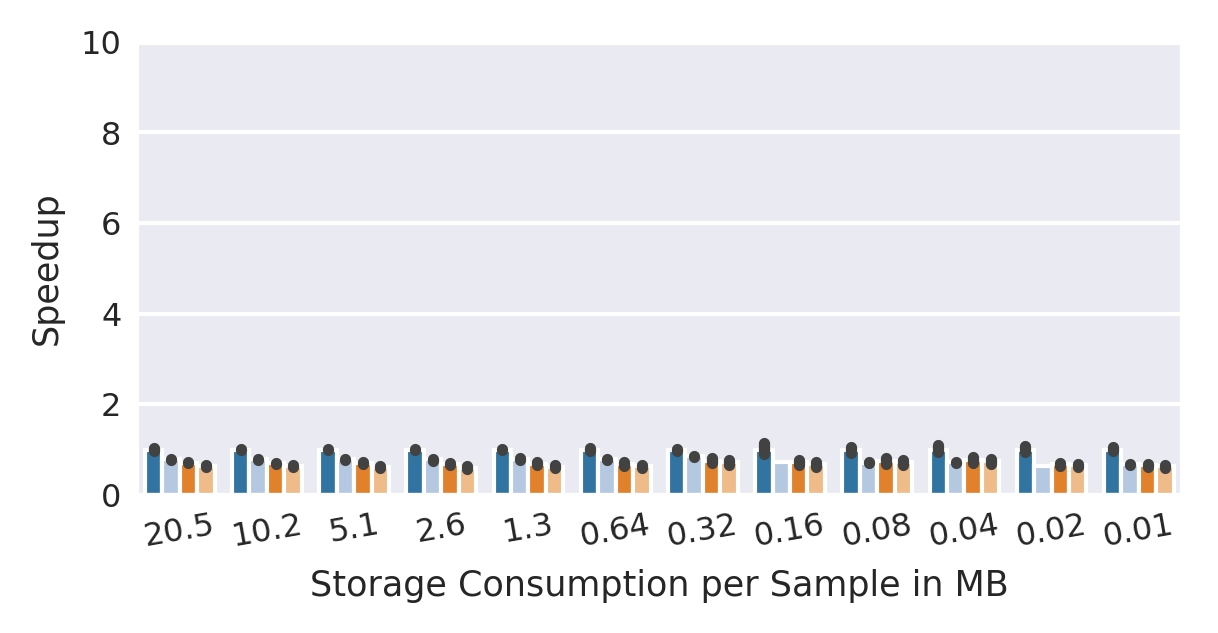

In [42]:
home_path = "../logs/type-logs/processing"
proc_type = "tf-for-loop-fn-wrapped"
path_cum_df = f"{home_path}/{proc_type}/temp-a.csv"
path_dstat_df = f"{home_path}/{proc_type}/temp-b.csv"

cum_df, cum_dstat_df = read_datatype_log(path_to_cum_df = path_cum_df
                                 , path_to_cum_dstat_df = path_dstat_df
                                 , proc_type = proc_type )

strategies_renamed = ["read-dataset"]
cum_df = cum_df.sort_values(by=["sample_count", "thread_count"])
par_df = create_speedup_df(df=cum_df)
plot = plot_speedup(par_df=par_df, cum_df=cum_df)
#plot.legend(title="Threads", ncol=1, labelspacing=0.05, loc=(0.005,0.58))
plot.get_legend().remove()
plot.set(ylim=(0, 10))
#save_fig("artificial-dataset-speedup-tf-raw")
#print_experiment_count(cum_df)

count       4.000000
mean     3980.804932
std       119.854973
min      3846.002441
25%      3897.777893
50%      3990.284302
75%      4073.311279
max      4096.648438
Name: online_processing_time_s, dtype: float64

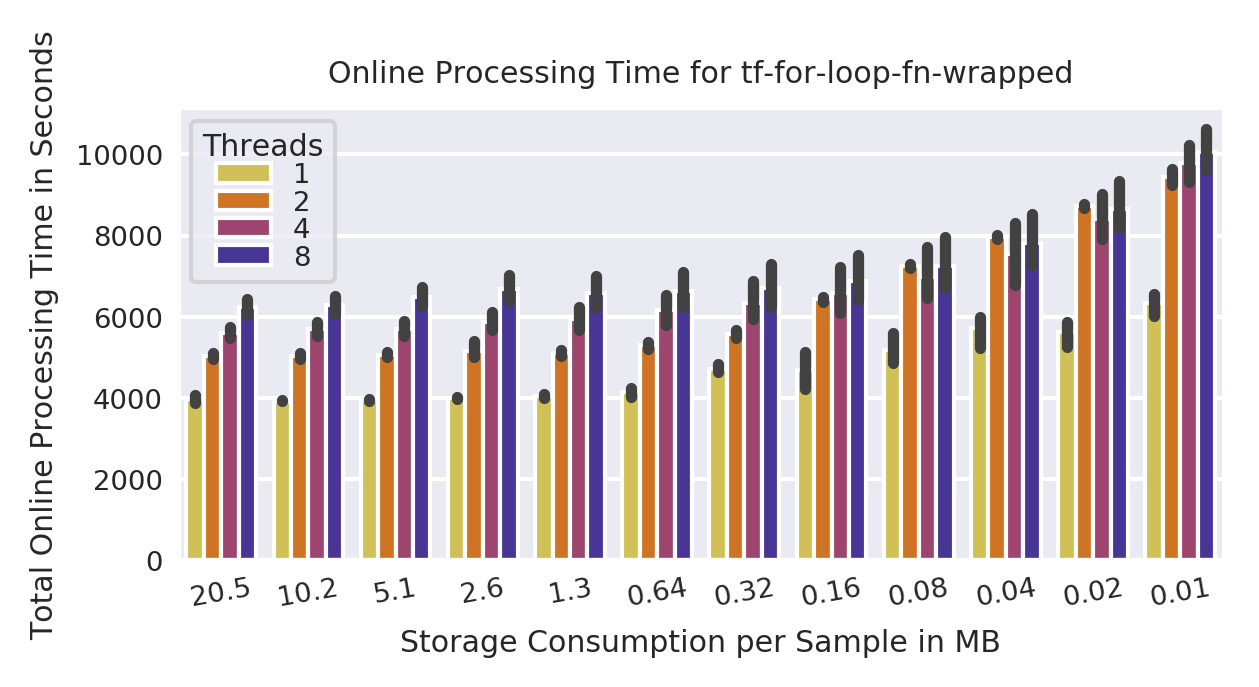

In [43]:
plot_online_time(cum_df=cum_df)
cum_df.query("sample_count==732 \
          and thread_count==1").describe()["online_processing_time_s"]